# Support Vector Machines (SVM) - Hard Margin Case
---
Recall the binary classification problem that SVMs try to solve. The hard margin SVM finds the seperating decision bounary with the largest margin. 

<img src="MaxMargin.jpg" height="400" width="400">

In this assigment, you will write the code to find the maximum margin for the hard margin case.

We showed in class that we could solve this problem  by reducing it to the problem of solving a quadratic programming problem (QP).  There are many solvers for quadratic programming problems. We will use the *Convex Optimization Library*, [CVXOPT](https://cvxopt.org/userguide/coneprog.html#quadratic-programming); a free software package that works well with Python and numpy. 
You will need to install [CVXOPT](https://cvxopt.org/install/)

In CVXOPT, the quadratic programming problem solver, <b><i>cvxopt.solvers.qp</i></b>,  solves the following problem:

$$\begin{eqnarray} \min_{x}\frac{1}{2} x^{T}Px - q^{T}x \nonumber \\\ \textrm{s.t.}\quad Gx \preceq h \\\ \textrm{and}\quad Ax = b \end{eqnarray}$$

 Note that $ Gx \preceq h $ is taken elementwise. 

The solver's (simplified) API is `cvxopt.solvers.qp(P, q, G, h, A, b)` 
where only $P$ and $q$ are required. 

You will need to match the solver's API.

The solver's argument's type must be CVXOPT matrices. I suggest you first create the arguments as NumpPy arrays and matrices and then convert them to CVXOPT matrices (For example, first import the library: `from cvxopt import matrix` then convert a NumPy matrix `P` to a CVXOPT matrix using ` P = matrix(P)`)

What is return by the solver  is a Python dictionary.  If you save the return value in a variable called `sol` (i.e. `sol = solvers.qp(...)`), you can access to the solution of the quadratic programming problem by typing `sol["x"]`.


# Hard Margin Case

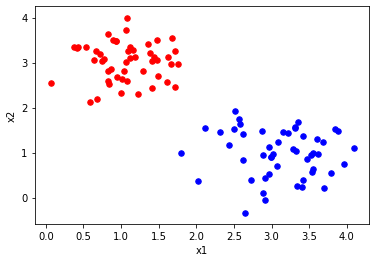

In [7]:
import numpy as np
import csv
from numpy import genfromtxt
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
import cvxopt
%matplotlib inline

# SVM explanation:
# https://medium.com/@zachary.bedell/support-vector-machines-explained-73f4ec363f13

# Use numpy function genfromtxt(…, delimiter=…) to load from files.

# Store the data from “X.csv” to X and target from “y.csv” to y
X = genfromtxt('X.csv',delimiter = ',')
y = genfromtxt('y.csv',delimiter = ',')

# Use np.where to find all index of data which y=1 and store them to idx_1
idx_1 = np.where( y == 1)

# same as y=-1, store them to idx_2
idx_2 = np.where(y == -1)

# make the plot use plt.scatter(X[idx_1,0], X[idx_1,1], s=30, c='b', marker="o")
def plot_data(X,y,idx_1,idx_2):
  plt.scatter(X[idx_1,0], X[idx_1,1], s=30, c='b', marker="o")
  plt.scatter(X[idx_2,0],X[idx_2,1],s=30,c='r',marker = "o")
  plt.xlabel("x1")
  plt.ylabel("x2")

plot_data(X,y,idx_1,idx_2)
# Set the x label with x1 and y label with x2

# plt.show()

## SVM Primal  Problem
---
### Problem 1.1
![qp.png](attachment:qp.png)
You will now use the quadratic problem solver to find the maximum margin for the SVM primal problem:

$$\begin{eqnarray}\left.\begin{aligned}  
&\min_{w}\frac{1}{2}||w||^{2} & \nonumber \\\ 
&\textrm{s.t.}  \quad y^{(i)}(w^{T}{\bf x}^{(i)} + w_0) \ge 1 \quad \forall i \end{aligned}\right.\end{eqnarray}$$


Look back at the lecture notes for the primal problem.  Please note that the variable names used in the lecture are different from the variable names given to decribe the API for CVXOPT's quadratic problem solver.


In [8]:
def linear_svm(X,y):
    solvers.options['show_progress'] = False
    
#     store the shape of X to two variables: N,F
    N,F = X.shape

#     create the Identity matrix using np.diag and np.ones
    I = np.identity(F)     

#     create the Q matrix using np.zeros
    Q = np.zeros((F+1,F+1))

#     for each element in Q:
    i = 1
    for row in range (F+1):
      for column in range(F+1):
        if i:
          # when row number is 0, set Q[row, col]=0
          if row == 0:
            Q[row,column]=0
          #when col number is 0 set Q[row,col]=0
          elif column == 0:
            Q[row,column]=0
          # else, compute Identity [row-1,col-1] and set it to Q[row,col]
          else:
            identity_shape = Q[row:,column:].shape
            identity = np.zeros(identity_shape)
            np.fill_diagonal(identity,1)
            Q[row:,column:] = identity
            i = 0
    
    # use cvxopt.matrix to create a new variable p with value Q
    P = cvxopt.matrix(Q)
    
    # use cvxopt.matrix to create a new variable q with value np.zeros(F+1)
    q = cvxopt.matrix(np.zeros(F+1))

    # create an empty list
    empty_list = []

    for n in range(N):
      # create a zero matric with size F+1
      zero_matrix = np.zeros(F+1)
      # for each element in the matric above:
      for element in range(F+1):
        # when the index=0, then set it to 1
        if element == 0:
          zero_matrix[element] = 1
        #  else, set the value to X[n].T[i-1]
        else:
          zero_matrix[element] = X[n].T[element-1]
      #  append the y[n]*updated matric to the empty list above (the one above the for loop
      empty_list.append(y[n]*zero_matrix)   
    # change the empty list to the np array and times -1
    empty_list = -1 * np.array(empty_list)

    # use cvxopt.matrix to convert above np array and store it in a variable: G
    G = cvxopt.matrix(empty_list)
    # create a variable named h with value np.ones(N)*-1 and convert it to cvxopt
    h = cvxopt.matrix(np.ones(N)*-1)
    # solve the primal using cvxopt.solvers.qp
    primal = cvxopt.solvers.qp(P,q,G,h)
    #  return the answer.
    return primal


# fit svm classifier
solution = linear_svm(X,y)
w = np.array(solution['x'])
print('Weights:\n',w)

Weights:
 [[ 0.46118099]
 [ 1.42189318]
 [-1.58830104]]


### Plotting the  decision boundary

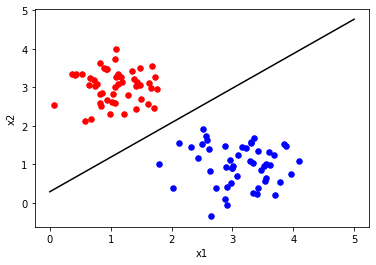

In [12]:
def plot_data_with_decision_boundary(X, y, w, fig_size=(15, 9), labels=['x1', 'x2']):
#     plot the dataset
  plot_data(X,y,idx_1,idx_2)

#     find the slope of the decision boundary
  slope = - w[1] / w[2]

#     find the intercept.
  y_intercept = -w[0] / w[2]

#     generate several x values np.arrange()
  x_values = np.arange(0, 6)

#     calculate its y values using intercept and slope
  y_values= x_values * slope + y_intercept

#     plot a line
  plt.plot(x_values,y_values,c="black")


# plotting the points and decision boundary using the above function   
plot_data_with_decision_boundary(X,y,w)

Determine which points are closest to the decision boundary. What is the functional margin of the points closest to the decision boundary?   

In [19]:
# calculate distance from each point to the decision boundary

# find the nearest data points and its index.

w_0 = w[0]
w_1 = w[1]
w_2 = w[2]
w_magnitude_sqrd= (w_1**2)+(w_2**2)
w_array = []
w_array.append(w1)
w_array.append(w2)
w_array = np.array(w_array)
r_values_list = []
for point in X:
  r = (w_array.T.dot(point.reshape(2,1)) + w0)/w_magnitude_sqrd
  r_values_list.append(r.tolist()[0][0])
r_values_list = np.abs(r_values_list)
index_smallest = np.argpartition(r_values_list,3)[:3]
margin = 2/((w_magnitude_sqrd)**(1/2))
print("The Margin is:",margin[0])
print("Points that are closest to decision boundary are: ")
print("Points Index: ",index_smallest)
print("Points: ")
print("Point 1",X[index_smallest[0]])
print("Point 2",X[index_smallest[1]])
print("Point 3",X[index_smallest[2]])


The Margin is: 0.9381836869408985
Points that are closest to decision boundary are: 
Points Index:  [68 49 25]
Points: 
Point 1 [1.71138733 2.45204836]
Point 2 [2.51879639 1.91565724]
Point 3 [2.11457352 1.5537852 ]


Write the decision function $f_{\texttt{primal}}({\bf x})$ to predict examples.  Use this function to predict the label of $(3.0, 1.5)^T$ and $(1.2, 3.0)^T$

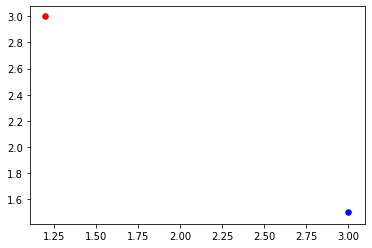

In [26]:
def f_primal(x):
#     return the predicted value using svm primal
  x = np.array(x)
  y = w_array.T.dot(x.reshape(2,1))+w0
  if (y >= 1):
    return 'b'
  else:
    return 'r'

# using f_ primal() to predict (3.0, 1.5) and (1.2, 3.0) and plot the figure.

point_1 = [3.0,1.5]
point_2 = [1.2,3.0]
p1_label = f_primal(point_1)
p2_label = f_primal(point_2)
plt.scatter(point_1[0], point_1[1], s=30, c=p1_label, marker="o")
plt.scatter(point_2[0], point_2[1], s=30, c=p2_label, marker="o")